<a href="https://colab.research.google.com/github/neelpatel710/NLP_Course_Project/blob/master/NLP_Project_SemanticSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [0]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
dataset = pd.read_csv('/content/drive/My Drive/Dataset/SICK_whole.txt',sep='\t')
print("SICK Dataset:")
dataset.head(10)

SICK Dataset:


,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


In [0]:
#Creating Corpus.
myCorpus = []
for index, row in dataset.iterrows():
  myCorpus.append(word_tokenize(row['sentence_A'].lower()))
  myCorpus.append(word_tokenize(row['sentence_B'].lower()))

In [0]:
# #Training Word2Vec on the Corpus.
common_terms = ["of", "with", "without", "and", "or", "the", "a"]
phrasesCombiningCommonTerms = Phrases(myCorpus, common_terms=common_terms)
bigram = Phraser(phrasesCombiningCommonTerms)
myCorpus = list(bigram[myCorpus])

In [0]:
#Training the Word2Vec model.
customModelWord2Vec = Word2Vec(myCorpus, min_count=3, size=200, window=3, iter=90)
torch.save(customModelWord2Vec,'/content/8_project_2_TT.pt')

In [0]:
loadModel = torch.load('/content/8_project_2_TT.pt')
word_vectors = loadModel.wv

**Algorithm Functions**

In [0]:
#Converting NLTK POS tag of wordNet POS tags. 
tagDict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
def wordNetTag(tag):
  return tagDict.get(tag[0].upper(),None)

In [0]:
#Removing stopwords, punctuations and performing lemmatization along with POS.
def performPreProcessing(sentence):
  posTag = None
  stopword = True
  posTaggingSent = nltk.pos_tag(word_tokenize(sentence))
  wordNet_Lemmatizer = WordNetLemmatizer()
  stopwords_english = stopwords.words("english")
  punctuations = ",.?:;()-'!`\""
  sentence = sentence.lower()
  tmpPhrase = []
  wordNetPosTagWithWords = {}
  wordTokens = word_tokenize(sentence)
  for eachWord in wordTokens:
    if eachWord in punctuations:
      continue
    if eachWord in stopwords_english and stopword:
      continue
    for p in range(len(posTaggingSent)):
      if eachWord == posTaggingSent[p][0]:
        posTag = wordNetTag(posTaggingSent[p][1])
    if posTag == None:
      rootWord = wordNet_Lemmatizer.lemmatize(eachWord)
    else:
      rootWord = wordNet_Lemmatizer.lemmatize(eachWord,pos=posTag)
      wordNetPosTagWithWords[rootWord] = posTag
    tmpPhrase.append(rootWord)
  return wordNetPosTagWithWords, tmpPhrase

In [0]:
def combinedUniqueWords(sentence1,sentence2,posTag1, posTag2):
  unionSet =  sentence1.copy()
  for word in sentence2:
    if not word in unionSet:
      unionSet.append(word)
  return unionSet

In [0]:
#Word2Vec model is used to compute word similarity.
def semanticVector(sentence):
  global unionSet_1_2
  vector = []
  for word in unionSet_1_2:
    if word in sentence:
      vector.append(1)
    else:
      tmpSimilar = {}
      #If word is not present in wordNet.
      for individualSentWord in sentence:
        if word in word_vectors.vocab and individualSentWord in word_vectors.vocab:
          wordSimilarity = loadModel.wv.similarity(word, individualSentWord)
        else:
          wordSimilarity = 0
        tmpSimilar[individualSentWord] = wordSimilarity
      #If the word is not similar to any other words of another sentence.
      if tmpSimilar != {}:
        argmax = sorted(tmpSimilar.items(), key=lambda x: x[1],reverse=True)
        final = argmax[0][1]
        vector.append(final)
      else:
        vector.append(0)
  return vector

In [0]:
#Compute Sentence Similarity - Cosine similarity.
def computeSimilarity(vector1, vector2):
  return np.dot(vector1, vector2)/(np.linalg.norm(vector1) * np.linalg.norm(vector2))

In [0]:
#Storing common words to compute word order vectors.
def commonWords(sentence1,sentence2):
  intersectSet = []
  for word1 in sentence1:
    for word2 in sentence2:
      if word1 == word2:
        if not word1 in intersectSet:
          intersectSet.append(word1)
  return intersectSet

In [0]:
#Computing word order vectors
def wordOrderVector(sentence1, sentence2):
  global intersectSet
  vector1, vector2 = [], []
  #Sentence length same but no common words.
  if intersectSet != []:
    vector1 = [i+1 for i in range(len(sentence1))]
    for word in sentence2:
      for wordSent1 in sentence1:
        if word == wordSent1:
          #Repeative of common word in same sentence.
          if not (sentence1.index(wordSent1)+1) in vector2:
            vector2.append(sentence1.index(wordSent1)+1)
  #Same length, having common words but interchanged places.
  if len(vector1) == len(vector2):
    return vector1, vector2
  else:
    return [], []

In [0]:
def computeWordOrderSimilarity(vector1, vector2):
  sub = np.subtract(vector1,vector2)
  add = np.add(vector1,vector2)
  return 1-((np.linalg.norm(sub) / np.linalg.norm(add)))

In [0]:
def semanticSimilarity(sentence1, sentence2):
  global unionSet_1_2, intersectSet
  # print("Sentence 1: "+sentence1)
  # print("Sentence 2: "+sentence2)
  #Preprocessing
  posTags1, processedSent1 = performPreProcessing(sentence1)
  posTags2, processedSent2 = performPreProcessing(sentence2)
  # print(processedSent1)
  # print(processedSent2)
  unionSet_1_2 = combinedUniqueWords(processedSent1,processedSent2, posTags1, posTags2)
  # print(len(unionSet_1_2))
  semVecSent1 = semanticVector(processedSent1)
  # print(semVecSent1)
  semVecSent2 = semanticVector(processedSent2)
  # print(semVecSent2)
  sentenceSimilarity = computeSimilarity(semVecSent1, semVecSent2)
  # Words same but interchanged
  if len(processedSent1) == len(processedSent2):
    e = 0.85
    intersectSet = commonWords(processedSent1, processedSent2)
    # print(intersectSet)
    # print(processedSent1,processedSent2)
    vec1, vec2 = wordOrderVector(processedSent1,processedSent2)
    # print(vec1, vec2)
    if vec1 == [] or vec2 == []:
      return sentenceSimilarity
    else:
      wordOrderSimilarity =  computeWordOrderSimilarity(vec1, vec2)
      #Completely same order.
      if wordOrderSimilarity != 0:
        return e*sentenceSimilarity + (1-e)*wordOrderSimilarity
      else:
        return sentenceSimilarity    
  else:
    return sentenceSimilarity

In [0]:
#Coverted percentage to scale of 1 to 5 for SICK dataset.
def generateCategory(x):
  return round(x*5,1) if round(x*5,1)!=0 else 1

In [0]:
#Computing accuracy based on the closeness of truth and predicted values.
def accuracy(x,y):
  acc = []
  for i in range(x.shape[0]):
    if(x[i] >= y[i]):
      acc.append(y[i]/x[i])
    else:
      acc.append(x[i]/y[i])
  return np.array(acc).mean()

In [17]:
#Performance against the dataset.
computedResults = []
for index, row in dataset.iterrows():
      unionSet_1_2, intersectSet = [], []
      result = semanticSimilarity(row['sentence_A'],row['sentence_B'])
      computedResults.append(generateCategory(result))

groundTruth = np.array(dataset['relatedness_score'])
print("Accuracy: " +str(accuracy(groundTruth,computedResults)))

Accuracy: 0.812769286568376


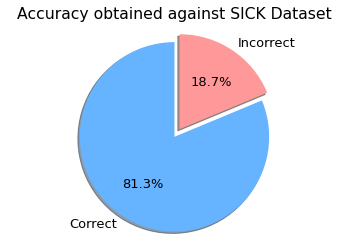

In [18]:
labels = 'Correct', 'Incorrect'
sizes = [accuracy(groundTruth,computedResults), 1-accuracy(groundTruth,computedResults)]
explode = (0.1, 0)
colors = ['#66b3ff','#ff9999']
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 13
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=colors, explode=explode,pctdistance=0.6, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Accuracy obtained against SICK Dataset')
plt.show()